![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Analyzing coherent structures in flows displaying transonic buffets

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from stl import mesh
import torch as pt
import numpy as np
from flowtorch import DATASETS
from flowtorch.data import FOAMDataloader, mask_box

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# create output directory
output = "output"
!mkdir -p $output

In [2]:
path = DATASETS["of_cylinder2D_binary"]
loader = FOAMDataloader(path)
times = loader.write_times
fields = loader.field_names
print(f"Number of available snapshots: {len(times)}")
print("First five write times: ", times[:5])
print(f"Fields available at t={times[-1]}: ", fields[times[-1]])

Number of available snapshots: 401
First five write times:  ['0', '0.025', '0.05', '0.075', '0.1']
Fields available at t=10:  ['p', 'vorticity', 'phi', 'U']


In [3]:
# load vertices and discard z-coordinate
vertices = loader.vertices[:, :2]
mask = mask_box(vertices, lower=[0.1, -1], upper=[0.75, 1])

Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


In [4]:
print(f"Selected vertices: {mask.sum().item()}/{mask.shape[0]}")

Selected vertices: 7190/13678


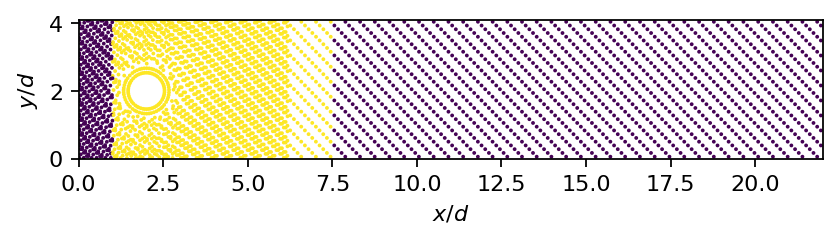

In [5]:
every = 4 # use only every 4th vertex
fig, ax = plt.subplots()
d = 0.1
ax.scatter(vertices[::every, 0]/d, vertices[::every, 1]/d, s=0.5, c=mask[::every])
ax.set_aspect("equal", 'box')
ax.set_xlim(0.0, 2.2/d)
ax.set_ylim(0.0, 0.41/d)
ax.set_xlabel(r"$x/d$")
ax.set_ylabel(r"$y/d$")
plt.savefig(f"{output}/cylinder_mask.svg", bbox_inches="tight")

In [6]:
window_times = [t for t in times if float(t) >= 4.0]
n_points = mask.sum().item()
U = pt.zeros((n_points, len(window_times)))
V = pt.zeros_like(U)
for i, t in enumerate(window_times):
    Utemp = loader.load_snapshot("U", t)
    U[:, i] = pt.masked_select(Utemp[:, 0], mask)
    V[:, i] = pt.masked_select(Utemp[:, 1], mask)

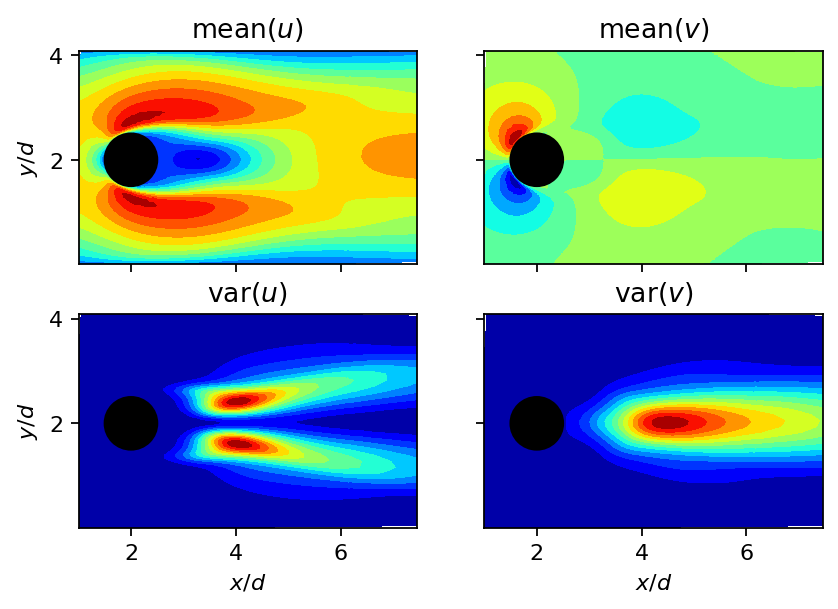

In [7]:
x = pt.masked_select(vertices[:, 0], mask)/d
y = pt.masked_select(vertices[:, 1], mask)/d

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
axarr[0, 0].tricontourf(x, y, U.mean(dim=1), levels=14, cmap="jet")
axarr[0, 1].tricontourf(x, y, V.mean(dim=1), levels=14, cmap="jet")
axarr[1, 0].tricontourf(x, y, U.var(dim=1), levels=14, cmap="jet")
axarr[1, 1].tricontourf(x, y, V.var(dim=1), levels=14, cmap="jet")
#axarr[0, 1].tricontour(x, y, svd.U[:, count], levels=14, linewidths=0.5, colors='k')

for ax in axarr.flatten():  
    ax.add_patch(plt.Circle((0.2/d, 0.2/d), 0.05/d, color='k'))
    ax.set_aspect("equal", 'box')
axarr[1, 0].set_xlabel(r"$x/d$")
axarr[1, 1].set_xlabel(r"$x/d$")
axarr[0, 0].set_ylabel(r"$y/d$")
axarr[1, 0].set_ylabel(r"$y/d$")
axarr[0, 0].set_title(r"$\mathrm{mean}(u)$")
axarr[0, 1].set_title(r"$\mathrm{mean}(v)$")
axarr[1, 0].set_title(r"$\mathrm{var}(u)$")
axarr[1, 1].set_title(r"$\mathrm{var}(v)$")
plt.savefig(f"{output}/cylinder_mean_var.svg", bbox_inches="tight")

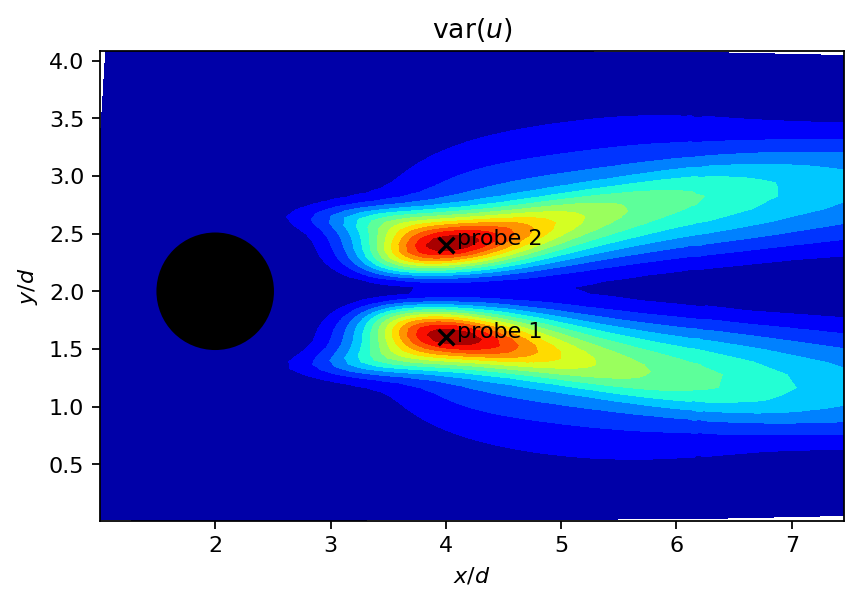

In [8]:
plt.tricontourf(x, y, U.var(dim=1), levels=14, cmap="jet")
plt.scatter([4, 4], [1.6, 2.4], c="k", marker="x", s=50)
plt.text(4.1, 1.6, "probe 1")
plt.text(4.1, 2.4, "probe 2")
ax = plt.gca()
ax.add_patch(plt.Circle((0.2/d, 0.2/d), 0.05/d, color='k'))
ax.set_aspect("equal", 'box')
plt.xlabel(r"$x/d$")
plt.ylabel(r"$y/d$")
plt.title(r"$\mathrm{var}(u)$")
plt.savefig(f"{output}/cylinder_Ux_var_markers.svg", bbox_inches="tight")

In [9]:
xy = pt.stack((x, y)).T
p1_id = pt.argmin((xy-pt.tensor([4.0, 1.6])).norm(dim=1))
p2_id = pt.argmin((xy-pt.tensor([4.0, 2.4])).norm(dim=1))
p1_id, p2_id

(tensor(806), tensor(813))

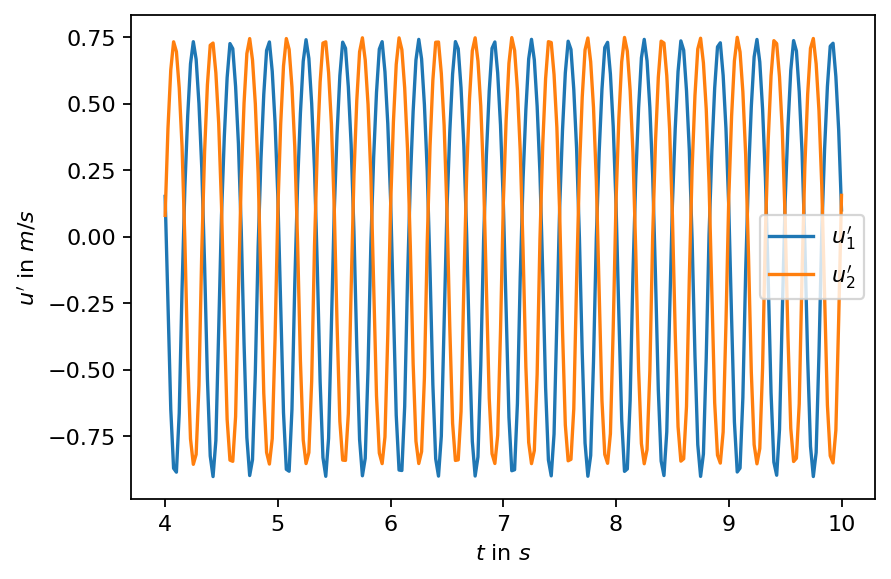

In [10]:
Up = U - U.mean(dim=1).unsqueeze(-1)
Up_p1 = Up[p1_id]
Up_p2 = Up[p2_id]
times_num = [float(t) for t in window_times]
plt.plot(times_num, Up_p1, label=r"$u_1^\prime$")
plt.plot(times_num, Up_p2, label=r"$u_2^\prime$")
plt.xlabel(r"$t$ in $s$")
plt.ylabel(r"$u^\prime$ in $m/s$")
plt.legend()
plt.savefig(f"{output}/Up_probes_vs_time.svg", bbox_inches="tight")

The basic idea of dimensionality reduction with PCA and related methods is as follows: if the observations are correlated, then there is some redundancy in the data, and we should be able to the data into a more effective representation. For example, to reduce the amount of data gathered from the two probe locations, we could remember only the observations of point one together with some meaningful relationship between observations from points one and two. In the visualization below, I assumed that $u^\prime_2(u^\prime_1) = - u^\prime_1$. As you can see, the new representation is not too bad. When plotting the observation of point one against those of point two, the canvas presents a two-dimensional space in which the observations lie. The position vector of each observation on the canvas has two components, one for $u^\prime_1$ and one for $u^\prime_2$. In other words, each sample point provides a direction (a basis vector) of the space containing the observations. This basis is naturally given to us by the points we picked and also by the basis in which the dataset is available (e.g., $u$ being the velocity component in $x$-direction and $x$ being the coordinate along the channel). If $u$ would not be the velocity component along the channel but along a slightly rotated axis, the plot below would look differently.

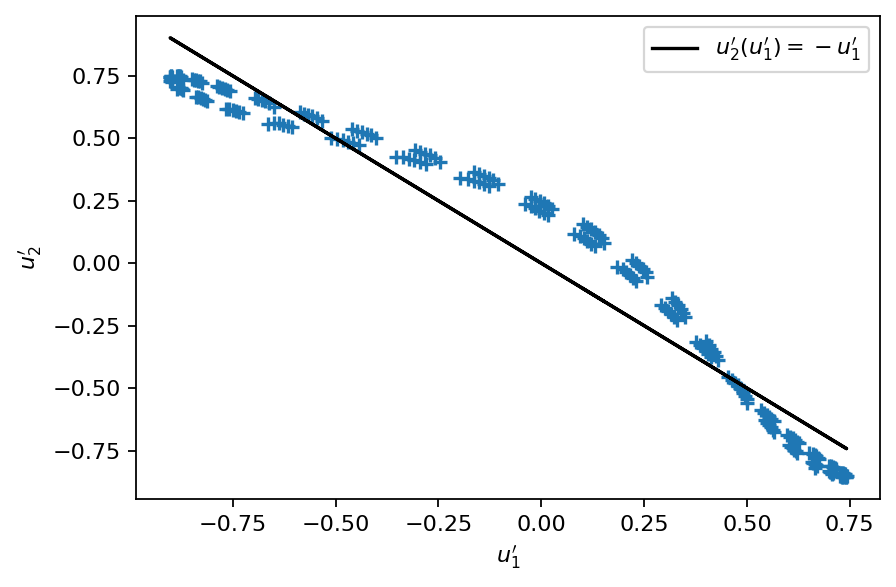

In [11]:
plt.scatter(Up_p1, Up_p2, marker="+")
plt.plot(Up_p1, -Up_p1, c="k", label=r"$u^\prime_2(u^\prime_1) = - u^\prime_1$")
plt.xlabel(r"$u_1^\prime$")
plt.ylabel(r"$u_2^\prime$")
plt.legend()
plt.savefig(f"{output}/Up1_vs_Up2.svg", bbox_inches="tight")

If the canvas above represents the space spanned by the natural basis, then the black line represents lower-dimensional subspace. One unit vector along the black line given in coordinates of the natural basis is $\mathbf{\phi}=(1/\sqrt{2}, -1/\sqrt{2})^T$ (look at the functional definition of the line if that is not clear). To get the coordinates of the observations along the $\mathbf{\phi}$ axis, we have to project every observation onto $\mathbf{\phi}$. Suppose we organize the velocity fluctuations of the two sample points in the following data matrix:
$$
\mathbf{X} = \left[
  \begin{array}{cccc}
|            & |            &     & | \\
\mathbf{u}^\prime_1 & \mathbf{u}^\prime_2 & ... & \mathbf{u}^\prime_{N} \\
|            & |            &     & | \\
\end{array}\right],
$$
where the index $j$ of $\mathbf{u}^\prime_j$ indicates the snapshot number and $N$ is the overall number of snapshots. Each column vector $\mathbf{u}^\prime_j$ has two rows, one for each sample point. The resulting data matrix is therefore $\mathbf{X}\in \mathbb{R}^{2\times N}$. To project all data points at once onto $\mathbf{\phi}$, we compute:
$$
  \mathbf{y} = \mathbf{\phi}^T \mathbf{X}.
$$
The resulting vector $\mathbf{y}$ is $\mathbf{y}\in \mathbb{R}^{1\times N}$ and contains the coordinate of each snapshot in the $\mathbf{\phi}$ basis. We can visualize the projected snapshot in the natural basis by multiplying the coordinate with the $\mathbf{\phi}$ vector.

data matrix of shape:  torch.Size([2, 241])


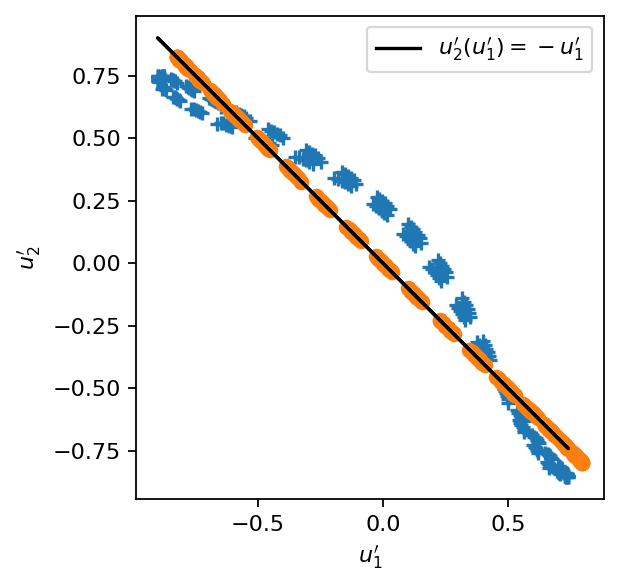

In [12]:
X = pt.stack((Up_p1, Up_p2))
print("data matrix of shape: ", X.shape)
phi_unit = pt.tensor([1.0, -1.0])
phi_unit /= phi_unit.norm()
y = phi_unit.reshape(1, 2) @ X
Y = (y.T @ phi_unit.reshape(1, 2)).T
plt.scatter(X[0, :], X[1, :], marker="+")
plt.scatter(Y[0, :], Y[1, :])
plt.plot(Up_p1, -Up_p1, c="k", label=r"$u^\prime_2(u^\prime_1) = - u^\prime_1$")
plt.gca().set_aspect("equal")
plt.xlabel(r"$u_1^\prime$")
plt.ylabel(r"$u_2^\prime$")
plt.legend()
plt.savefig(f"{output}/Up12_proj.svg", bbox_inches="tight")

We can see that the data points are much more spread along the new $\mathbf{\phi}$ axis. To measure the spread, we can compute the variance of the projection onto $\mathbf{\phi}$:
$$
  \mathrm{var}(\mathbf{y}) = \mathbf{yy}^T = \mathbf{\phi}^T \mathbf{X} (\mathbf{\phi}^T \mathbf{X})^T = \mathbf{\phi}^T \mathbf{XX}^T \mathbf{\phi}
$$
The matrix $\mathbf{XX}^T$ is $2\times 2$ matrix in the present example. If we substituted $\mathbf{\phi}$ with the first unit vector of the natural basis $\mathbf{e}_1 = (1, 0)^T$ then we would effectively extract the first row of the first column of $\mathbf{XX}^T$, which is $N-1$ times the sample variance of $u^\prime_1$. If we computed instead $\mathbf{e}_2^T \mathbf{XX}^T \mathbf{e}_1$, we would extract the second row of the first colum of $\mathbf{XX}^T$, which is $N-1$ times the sample covariance between $u^\prime_1$ and  $u^\prime_2$. Therefore, the so-called covariance matrix is defined as follows:
$$
  \mathbf{C} = \frac{1}{N-1} \mathbf{XX}^T.
$$
[This article](https://www.willemsleegers.com/posts/why-divide-by-n-1/) provides a nice and intuitive reasoning for the pre-factor $N-1$. The covariance matrix of the data in the natural basis is computed and depicted below.

Variance along new dimension (phi):  0.6717532475789388


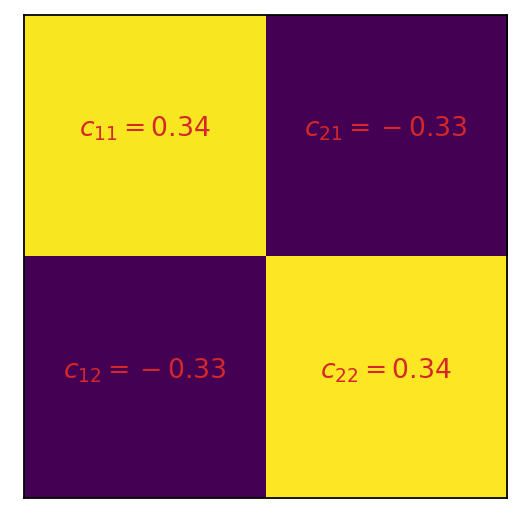

In [13]:
N = X.shape[1]
print("Variance along new dimension (phi): ", (y @ y.T).item() /  (N-1))
C = (X @ X.T) / (N - 1)
plt.imshow(C)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        ind = f"{i}{j}"
        text = r"$c_{" + f"{i+1}{j+1}" + r"}=" + f"{C[i, j]:2.2f}$"
        plt.text(i, j, text, c="C3", fontsize=12, ha="center")
plt.savefig(f"{output}/cov_org.svg", bbox_inches="tight")

The new unit vector $\mathbf{\phi}$ we experimented with before corresponds to the unit vector $\mathbf{e}_1$ rotated by $-45^\circ$. The variance along the new dimension was significantly larger than any coefficient of $\mathbf{C}$. We can execute another small experiment and test the rotation by several different  $\beta$ affect the covariance matrix. The first and second unit vector of the rotated basis are obtained by multiplying the corresponding unit vector of the natural basis by the rotation matrix:
$$
  \mathbf{\phi}_1 = \mathbf{Re}_1\quad\text{and}\quad \mathbf{\phi}_2 = \mathbf{Re}_2,
$$
with $\mathbf{R}$ being:
$$
\mathbf{R} = \left[
  \begin{array}{cc}
  \mathrm{cos}(\beta) & -\mathrm{sin}(\beta) \\
  \mathrm{sin}(\beta) &  \mathrm{cos}(\beta) \\
\end{array}\right].
$$

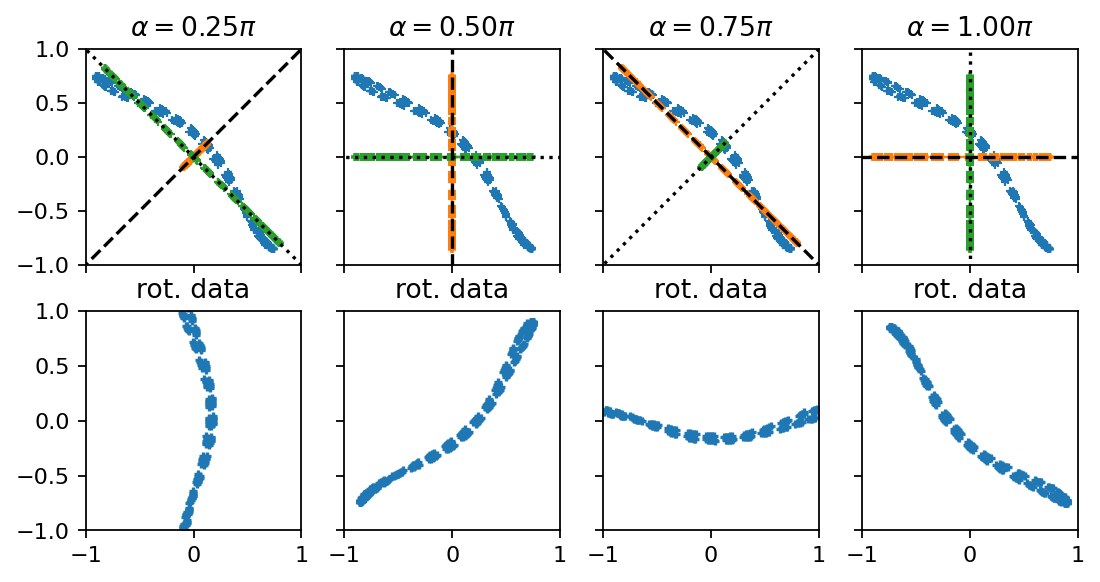

In [14]:
def rotate_vector(vector, angle):
    rot_matrix = pt.tensor([[pt.cos(angle), -pt.sin(angle)], [pt.sin(angle), pt.cos(angle)]])
    return rot_matrix @ vector

fig, axarr = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True)
angles = pt.linspace(0.25, 1, 4) * np.pi
origin = pt.zeros(2)
unit_1 = pt.tensor([1, 0], dtype=pt.float32)
for i, angle in enumerate(angles):
    phi_1 = rotate_vector(unit_1, angle)
    phi_2 = rotate_vector(unit_1, angle+np.pi*0.5)
    axis_1 = pt.stack((-phi_1, phi_1))
    axis_2 = pt.stack((-phi_2, phi_2))
    Y_1 = phi_1.reshape(2, 1) * (phi_1.reshape(1, 2) @ X)
    Y_2 = phi_2.reshape(2, 1) * (phi_2.reshape(1, 2) @ X)
    axarr[0, i].plot(axis_1[:, 0]*1.5, axis_1[:, 1]*1.5, c="k", ls="--")
    axarr[0, i].plot(axis_2[:, 0]*1.5, axis_2[:, 1]*1.5, c="k", ls=":")
    axarr[0, i].scatter(X[0, :], X[1, :], marker="+", lw=1, s=10)
    axarr[0, i].scatter(Y_1[0, :], Y_1[1, :], marker="+", lw=1, s=10)
    axarr[0, i].scatter(Y_2[0, :], Y_2[1, :], marker="+", lw=1, s=10)
    axarr[0, i].set_aspect("equal")
    axarr[0, i].set_xlim(-1, 1)
    axarr[0, i].set_ylim(-1, 1)
    phi = pt.stack((phi_1, phi_2)).T
    X_pro = X.T @ phi
    axarr[1, i].scatter(X_pro[:, 0], X_pro[:, 1], marker="+", s=10)
    axarr[0, i].set_title(r"$\alpha = {:1.2f}\pi$".format(angle/np.pi))
    axarr[1, i].set_title("rot. data")
plt.savefig(f"{output}/rotated_data.svg", bbox_inches="tight")

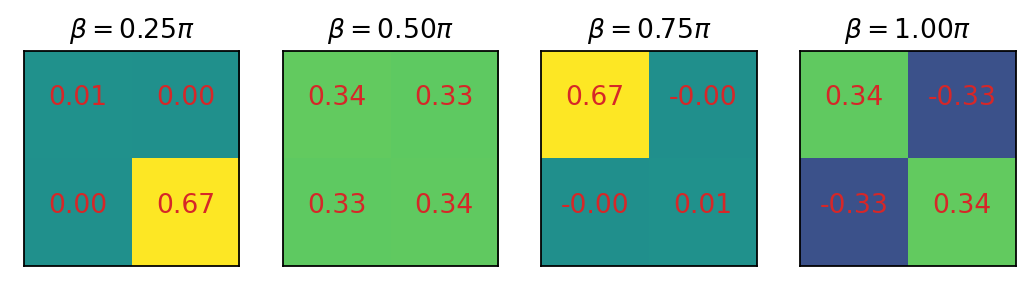

In [15]:
fig, axarr = plt.subplots(1, 4, figsize=(8, 4), sharex=True, sharey=True)
angles = pt.linspace(0.25, 1, 4) * np.pi
origin = pt.zeros(2)
unit_1 = pt.tensor([1, 0], dtype=pt.float32)
for i, angle in enumerate(angles):
    new_unit_1 = rotate_vector(unit_1, angle)
    new_unit_2 = rotate_vector(unit_1, angle+np.pi*0.5)
    phi = pt.stack((new_unit_1, new_unit_2)).T
    X_pro = (X.T @ phi).T
    C_pro = (X_pro @ X_pro.T) / (N -1)
    axarr[i].imshow(C_pro, vmin=-0.66, vmax=0.66)
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title(r"$\beta = {:1.2f}\pi$".format(angle/np.pi))
    for k in range(C.shape[0]):
        for l in range(C.shape[1]):
            axarr[i].text(k, l, f"{C_pro[k, l]:2.2f}", c="C3", fontsize=12, ha="center")
plt.savefig(f"{output}/cov_rotated_data.svg", bbox_inches="tight")

As we can see, choosing a favorable new basis, like a $45^\circ$ rotated version of the natural basis, tends to reduce the off-diagonal coefficients of the covariance matrix while one of the diagonal coefficients becomes much larger. We can now use this observation to define a clear metric according to which we choose an optimal new basis. In the PCA, the first axis is chosen such that the variance along this axis is maximal under the condition that the new basis vector is a unit vector:
$$
  \underset{\mathbf{\phi}_1}{\mathrm{max}}( \mathbf{\phi}^T_1 \mathbf{C} \mathbf{\phi}_1)\quad\text{given that}\quad \mathbf{\phi}^T_1\mathbf{\phi}_1 = 1.
$$
To solve the optimization problem, we use the method of [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier), which entails subtracting $\lambda$ times the constrained from the objective function (the variance along the new axis):
$$
L(\mathbf{\phi}_1, \lambda) =  \mathbf{\phi}^T_1 \mathbf{C} \mathbf{\phi}_1 - l(\mathbf{\phi}^T_1\mathbf{\phi}_1 - 1),
$$
where $\lambda$ is the Lagrange multiplier. The new objective function is quadratic in the component of $\mathbf{\phi}_1$ (compute the above equation for a generic $2\times 2$ it that's not clear yet). To find the maximum, we compute the derivative with respect to $\mathbf{\phi}_1$ and set it to zero. Note that the derivative of the scalar objective function with resect to a vector yields a vector:
$$
  \frac{\partial L}{\partial \mathbf{\phi}} = 2\mathbf{C}\mathbf{\phi}_1 - 2\lambda \mathbf{\phi}_1 = \mathbf{0}.
$$
Refactoring the derivative yields an eigenvalue problem:
$$
  \mathbf{C\phi}_1 = \lambda \mathbf{\phi}_1.
$$
The equation above says that the objective function is maximized of the Lagrange multiplier is an eigenvalue of the covariance matrix and $\mathbf{\phi}$ is the corresponding eigenvector. However, in the current problem, $\mathbf{C}$ is a $2\times 2$ and could have two non-negative eigenvalues (the (co)variance is always larger or equal to zero; see [positive semi-definite matrix](https://en.wikipedia.org/wiki/Definite_matrix)), so which eigenvalue/eigenvector pair is the one we are searching? To solve this mystery it suffices to $\mathbf{C\phi}_1$ in the maximization problem with $\lambda \mathbf{\phi}_1$:
$$
  \mathbf{\phi}^T_1 \mathbf{C} \mathbf{\phi}_1 = \lambda\mathbf{\phi}^T_1\mathbf{\phi}_1 = \lambda.
$$
Now it becomes clear that the maximum eigenvalue maximizes the objective function. Let's say we compute the eigen decomposition of the covariance matrix:
$$
  \mathbf{C} = \mathbf{\Phi \Lambda \Phi}^{-1}\quad\text{given that}\quad \mathbf{\phi}^T_1\mathbf{\phi}_1 = 1,
$$
where the column vectors of $\mathbf{\Phi}$ are the eigenvectors and the diagonal coefficients of $\mathbf{Lambda}$ are the eigenvalues of the covariance matrix. The eigenvectors $\mathbf{\phi}_i$ form an orthonormal basis because the covariance matrix is symmetric. If the eigenvectors are sorted according to the eigenvalues in descending order, then the new basis vector with the second largest variance is the eigenvector with the second largest eigenvalue and so on. The eigenvectors of the covariance matrix are also referred to as principal components. The eigenvalues correspond to the variance along each new axis.

In [16]:
C = (X @ X.T) / (N - 1)
vals, vecs = pt.linalg.eigh(C)
vals, indices = pt.sort(vals, descending=True)
vecs = vecs[:, indices]
print(vals)

tensor([0.6718, 0.0096])


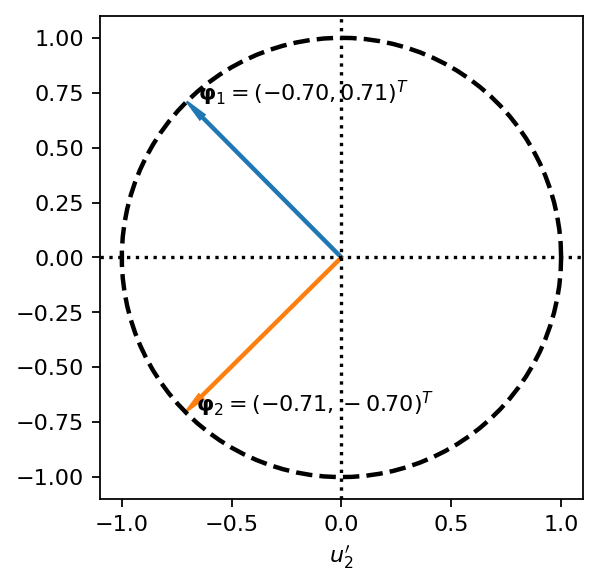

In [17]:
t = pt.linspace(0, 2 * np.pi, 100)
plt.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
plt.gca().set_aspect("equal")
plt.xlabel(r"$u_1^\prime$")
plt.xlabel(r"$u_2^\prime$")
plt.axhline(0.0, ls=":", c="k")
plt.axvline(0.0, ls=":", c="k")
plt.arrow(0, 0, *vecs[:, 0]*(1-0.1), width=0.01, head_length=0.1, color="C0")
plt.arrow(0, 0, *vecs[:, 1]*(1-0.1), width=0.01, head_length=0.1, color="C1")
plt.text(vecs[0, 0]+0.05, vecs[1, 0], r"$\mathbf{\varphi}_1 = " + r"({:1.2f} , {:1.2f})^T$".format(*vecs[:, 0]))
plt.text(vecs[0, 1]+0.05, vecs[1, 1], r"$\mathbf{\varphi}_2 = " + r"({:1.2f} , {:1.2f})^T$".format(*vecs[:, 1]))
plt.savefig(f"{output}/cov_eigvecs_2D.svg", bbox_inches="tight")

the mode coefficients are defined as
$$
  \mathbf{A} = \mathbf{\Phi}^T \mathbf{X}
$$
note that
$$
  \mathbf{A}^T = (\mathbf{\Phi}^T \mathbf{X})^T = \mathbf{X}^T \mathbf{\Phi}
$$
and
$$
  \mathbf{X} = \mathbf{\Phi A}
$$

In [18]:
A = vecs.T @ X
A.shape

torch.Size([2, 241])

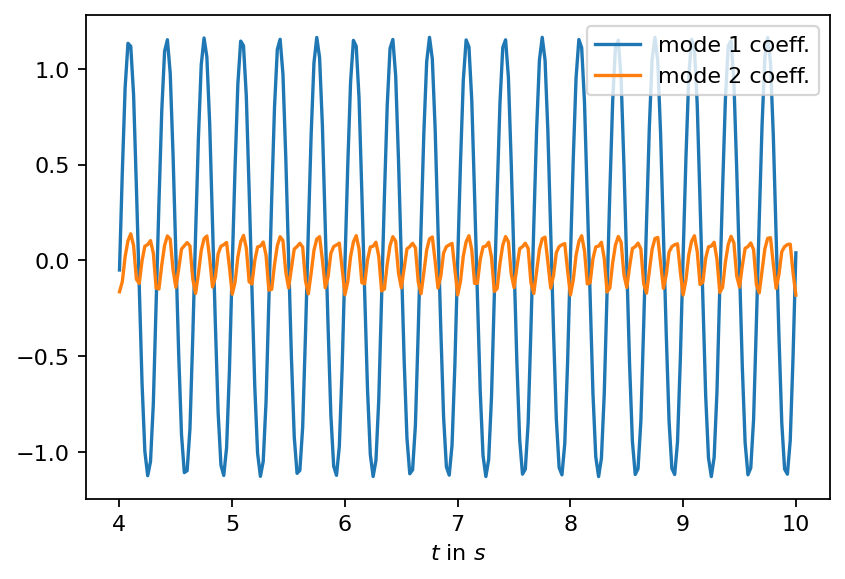

In [19]:
plt.plot(times_num, A[0, :], label="mode 1 coeff.")
plt.plot(times_num, A[1, :], label="mode 2 coeff.")
plt.xlabel(r"$t$ in $s$")
plt.legend()
plt.savefig(f"{output}/mode_coeffs_2points.svg", bbox_inches="tight")

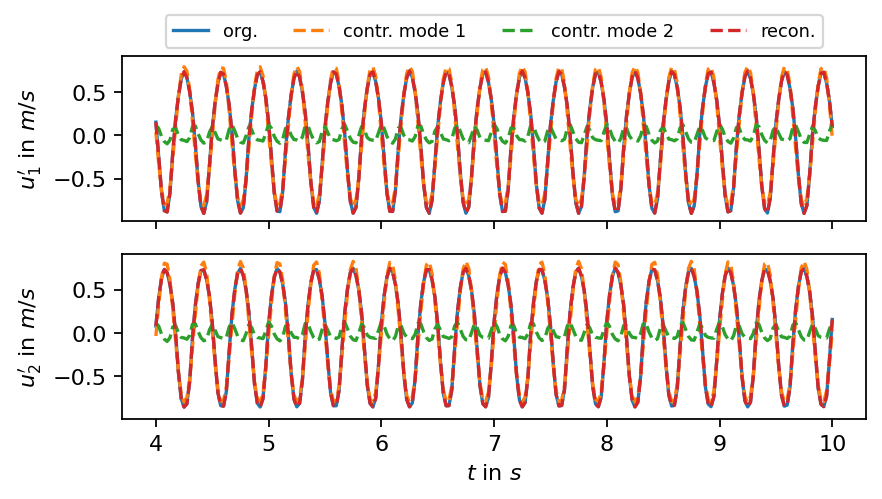

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3), sharex=True, sharey=True)
X_11 = vecs[0, 0] * A[0, :]
X_12 = vecs[0, 1] * A[1, :]
X_21 = vecs[1, 0] * A[0, :]
X_22 = vecs[1, 1] * A[1, :]

ax1.plot(times_num, X[0, :], ls="-", label="org.")
ax1.plot(times_num, X_11, ls="--", label="contr. mode 1")
ax1.plot(times_num, X_12, ls="--", label="contr. mode 2")
ax1.plot(times_num, X_11+X_12, ls="--", label="recon.")
ax2.plot(times_num, X[1, :], ls="-")
ax2.plot(times_num, X_21, ls="--")
ax2.plot(times_num, X_22, ls="--")
ax2.plot(times_num, X_21+X_22, ls="--")
ax2.set_xlabel(r"$t$ in $s$")
ax1.set_ylabel(r"$u_1^\prime$ in $m/s$")
ax2.set_ylabel(r"$u_2^\prime$ in $m/s$")
ax1.legend(ncol=4, fontsize=8, bbox_to_anchor=(0.5, 1.15), loc="center")
plt.savefig(f"{output}/mode_recon_2points.svg", bbox_inches="tight")

In [21]:
C_direct = (Up @ Up.T) / (N - 1)
vals, vecs = pt.linalg.eigh(C_direct)
vals, indices = pt.sort(vals, descending=True)
vecs = vecs[:, indices]

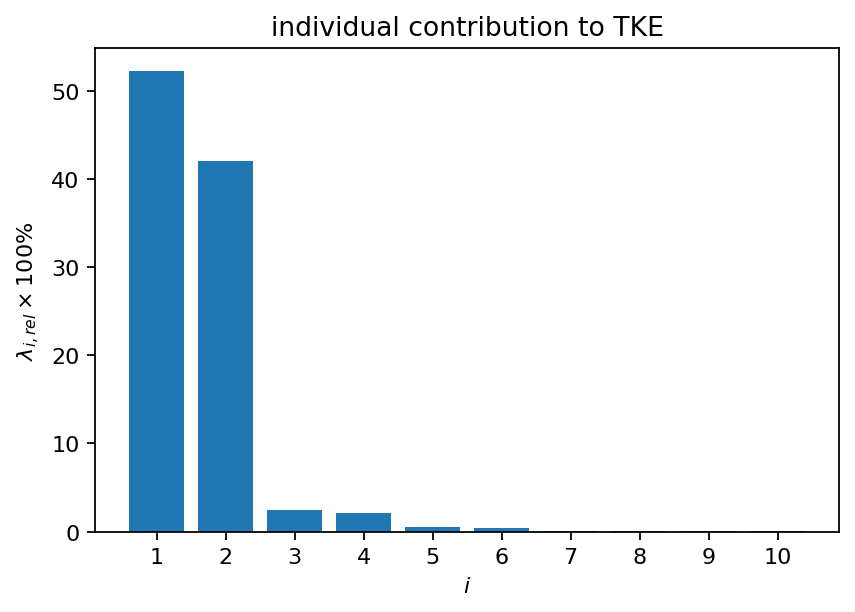

In [22]:
plt.bar(range(1, 11), vals[:10]/vals.sum()*100)
plt.gca().set_xticks(range(1, 11))
plt.xlabel(r"$i$")
plt.ylabel(r"$\lambda_{i,rel} \times 100\%$")
plt.title("individual contribution to TKE")
plt.savefig(f"{output}/Up_cylinder_eigvals.svg", bbox_inches="tight")

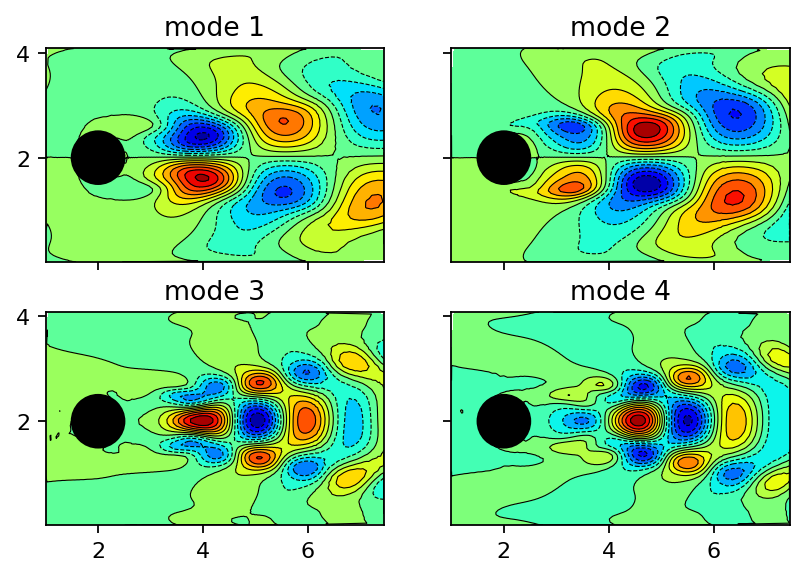

In [23]:
x = pt.masked_select(vertices[:, 0], mask)/d
y = pt.masked_select(vertices[:, 1], mask)/d

fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        axarr[row, col].tricontourf(x, y, vecs[:, count], levels=14, cmap="jet")
        axarr[row, col].tricontour(x, y, vecs[:, count], levels=14, linewidths=0.5, colors='k')
        axarr[row, col].add_patch(plt.Circle((0.2/d, 0.2/d), 0.05/d, color='k'))
        axarr[row, col].set_aspect("equal", 'box')
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode {count + 1}")
        count += 1
plt.savefig(f"{output}/Up_cylinder_eigvecs.svg", bbox_inches="tight")

singular value decomposition
$$
  \mathbf{X} = \mathbf{U\Sigma V}^T
$$

- left/right singular vectors are unitary
- non-zero part of $\mathbf{\Sigma}$ is a diagonal matrix

direct PCA by means of SVD
$$
  \mathbf{C} = \frac{1}{N-1}\mathbf{XX}^T = \frac{1}{N-1} \mathbf{U\Sigma V}^T\mathbf{V\Sigma}^T\mathbf{U}^T =  \frac{1}{N-1} \mathbf{U\Sigma}^2\mathbf{U}^T = \mathbf{\Phi\Lambda\Phi}^T
$$
- principal components are equivalent to the left singular vectors
- eigenvalues times $N-1$ equals singular values squared: $\mathbf{\Lambda} = \frac{\mathbf{\Sigma}^2}{N-1}$
- singular values times right singular values are mode coefficients

snapshot covariance matrix
$$
  \mathbf{C}_s = \frac{1}{N-1} \mathbf{X}^T\mathbf{X} = \mathbf{\Phi}_s\mathbf{\Lambda}_s\mathbf{\Phi}_s^T
$$

$$
  \mathbf{C}_s = \frac{1}{N-1} \mathbf{V\Sigma}^T\mathbf{U}^T\mathbf{U\Sigma V}^T = \frac{1}{N-1} \mathbf{V\Sigma}^2\mathbf{V}^T = \mathbf{\Phi}_s\mathbf{\Lambda}_s\mathbf{\Phi}_s^T
$$

getting the principal modes:
$$
  \mathbf{X\Phi}_s = \mathbf{U\Sigma V}^T\mathbf{\Phi}_s = \mathbf{U\Sigma V}^T\mathbf{V} = \mathbf{U\Sigma}
$$

$$
  \mathbf{\Phi} = \mathbf{U} = \mathbf{X\Phi}_s\mathbf{\Sigma}^{-1} = \mathbf{X\Phi}_s (\mathbf{\Lambda}_s(N-1))^{-1/2}
$$

- eigenvalues of $\mathbf{C}$ and $\mathbf{C}_s$ are the same
- eigenvectors correspond to normalized mode coefficients/right singular vectors

In [24]:
C_snap = Up.T @ Up / (N - 1)
vals_s, vecs_s = pt.linalg.eigh(C_snap)
vals_s, indices = pt.sort(vals_s, descending=True)
vecs_s = vecs_s[:, indices]

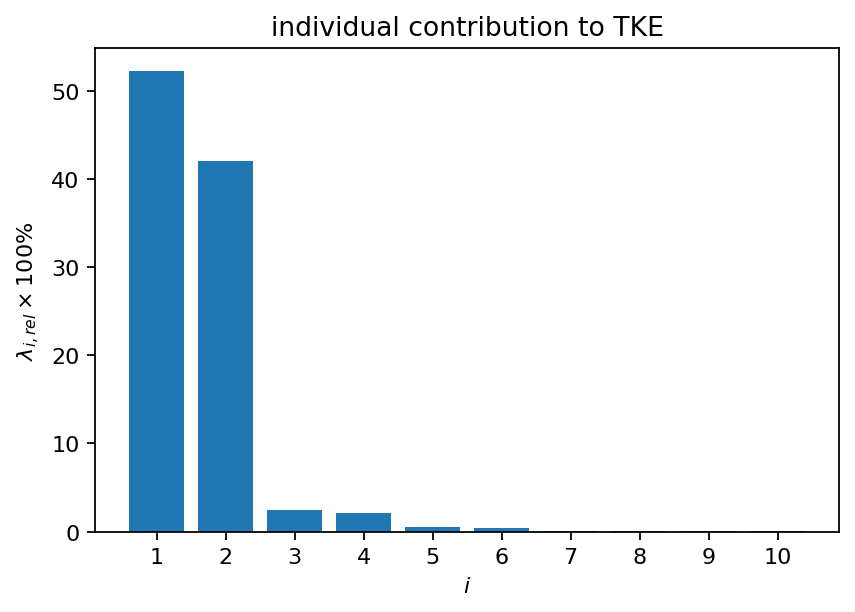

In [25]:
plt.bar(range(1, 11), vals_s[:10]/vals_s.sum()*100)
plt.gca().set_xticks(range(1, 11))
plt.xlabel(r"$i$")
plt.ylabel(r"$\lambda_{i,rel} \times 100\%$")
plt.title("individual contribution to TKE")
plt.savefig(f"{output}/Up_cylinder_eigvals_snap.svg", bbox_inches="tight")

In [26]:
scale = pt.sqrt(1.0 / vals_s / (N-1))
modes_s = (Up @ vecs_s) * scale

In [27]:
(vecs[:, :10] - modes_s[:, :10]).sum()

tensor(0.3125)

In [28]:
Vp = V - V.mean(dim=1).unsqueeze(-1)
X = pt.zeros(n_points*2, N)
X[:n_points, :] = Up
X[n_points:, :] = Vp
C_snap = X.T @ X / (N - 1)
vals_s, vecs_s = pt.linalg.eigh(C_snap)
vals_s, indices = pt.sort(vals_s, descending=True)
vecs_s = vecs_s[:, indices]
scale = pt.sqrt(1.0 / vals_s / (N-1))
modes_s = (X @ vecs_s) * scale

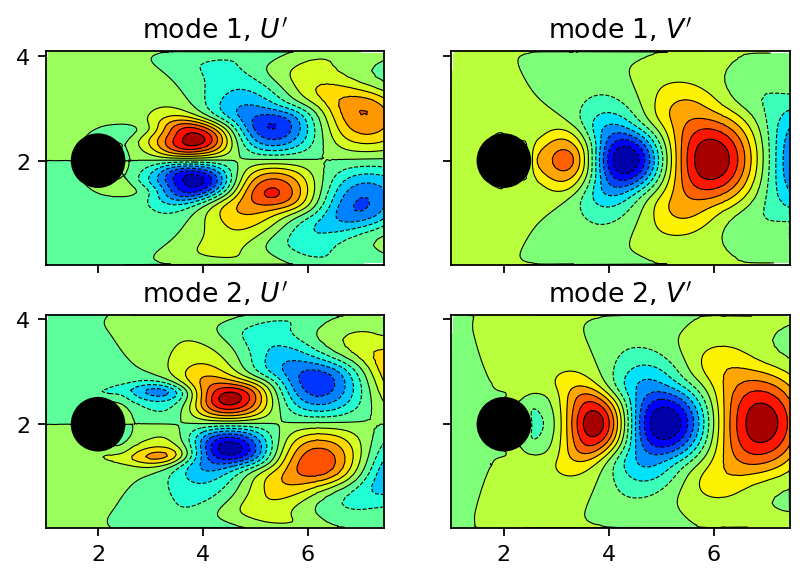

In [29]:
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
count = 0
for row in range(2):
    axarr[row, 0].tricontourf(x, y, modes_s[:n_points, row], levels=14, cmap="jet")
    axarr[row, 0].tricontour(x, y, modes_s[:n_points, row], levels=14, linewidths=0.5, colors='k')
    axarr[row, 1].tricontourf(x, y, modes_s[n_points:, row], levels=14, cmap="jet")
    axarr[row, 1].tricontour(x, y, modes_s[n_points:, row], levels=14, linewidths=0.5, colors='k')
    for ax in axarr[row, :]:
        ax.add_patch(plt.Circle((0.2/d, 0.2/d), 0.05/d, color='k'))
        ax.set_aspect("equal", 'box')
    # add 1 for the POD mode number since we subtracted the mean
    axarr[row, 0].set_title(f"mode {row + 1}, " + "$U^\prime$")
    axarr[row, 1].set_title(f"mode {row + 1}, " + "$V^\prime$")
plt.savefig(f"{output}/UV_cylinder_eigvecs.svg", bbox_inches="tight")

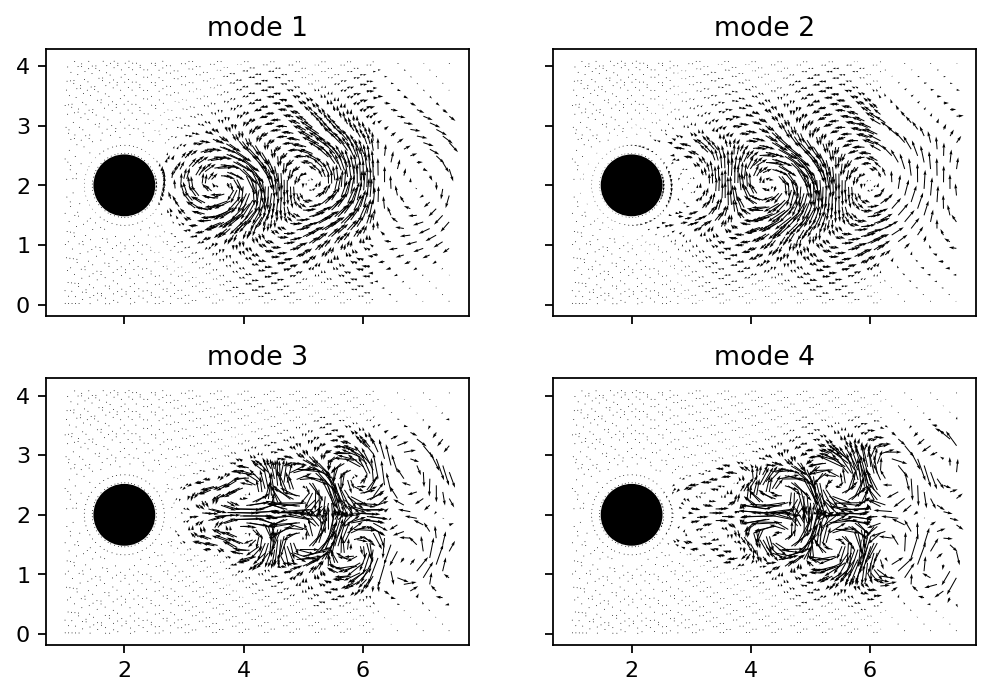

In [30]:
fig, axarr = plt.subplots(2, 2, figsize=(7.5, 5), sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        axarr[row, col].quiver(x[::4], y[::4], modes_s[:n_points:4, count], modes_s[n_points::4, count])
        axarr[row, col].add_patch(plt.Circle((0.2/d, 0.2/d), 0.05/d, color='k'))
        axarr[row, col].set_aspect("equal", 'box')
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode {count + 1}")
        count += 1
plt.savefig(f"{output}/cylinder_modes_quiver.svg", bbox_inches="tight")

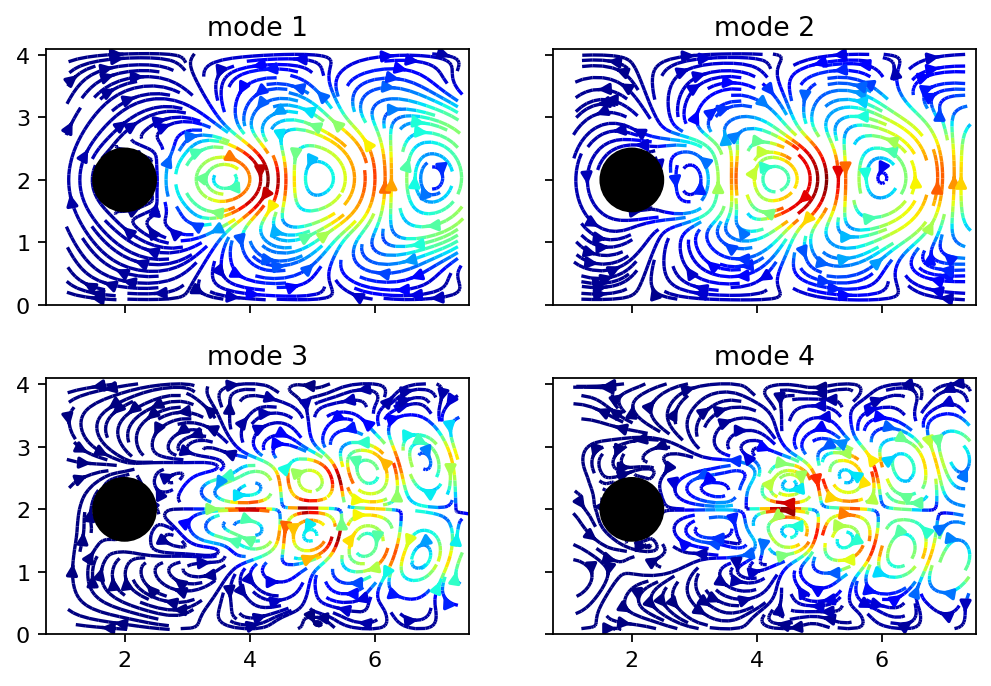

In [31]:
triang = tri.Triangulation(x, y)
xi = np.linspace(0, 7.5, 100)
yi = np.linspace(0, 4.1, int(100*4.1/7.5))
Xi, Yi = np.meshgrid(xi, yi)

fig, axarr = plt.subplots(2, 2, figsize=(7.5, 5), sharex=True, sharey=True)
count = 0
for row in range(2):
    for col in range(2):
        interpolatorU = tri.LinearTriInterpolator(triang, modes_s[:n_points, count].numpy())
        interpolatorV = tri.LinearTriInterpolator(triang, modes_s[n_points:, count].numpy())
        Ui = interpolatorU(Xi, Yi)
        Vi = interpolatorV(Xi, Yi)
        mag = np.sqrt(Ui**2 + Vi**2)
        axarr[row, col].streamplot(xi, yi, Ui, Vi, color=mag, density=1.5, cmap="jet")
        axarr[row, col].add_patch(plt.Circle((0.2/d, 0.2/d), 0.05/d, color='k', zorder=5))
        axarr[row, col].set_aspect("equal", 'box')
        # add 1 for the POD mode number since we subtracted the mean
        axarr[row, col].set_title(f"mode {count + 1}")
        count += 1
plt.savefig(f"{output}/cylinder_modes_streamplot.svg", bbox_inches="tight")

In [32]:
naca_data = "../datasets/naca0012_buffet/"
xa = pt.load(naca_data + "x_masked_3D_ref0_lecture.pt")
ya = pt.load(naca_data + "y_masked_3D_ref0_lecture.pt")
vol = pt.load(naca_data + "vol_masked_3D_ref0_lecture.pt")
Uxy = pt.load(naca_data + "U_masked_3D_ref0_lecture.pt")

In [33]:
def add_naca0012_patch(axis, scale=1.0):
    x_up = naca_stl.x[naca_stl.y > 0] * scale
    y_up = naca_stl.y[naca_stl.y > 0] * scale
    x_low = naca_stl.x[naca_stl.y < 0] * scale
    y_low = naca_stl.y[naca_stl.y < 0] * scale
    axis.fill_between(x_up, 0.0, y_up, color="k", zorder=5)
    axis.fill_between(x_low, y_low, 0.0, color="k", zorder=5)
    
naca_stl = mesh.Mesh.from_file(naca_data + "naca0012.stl")

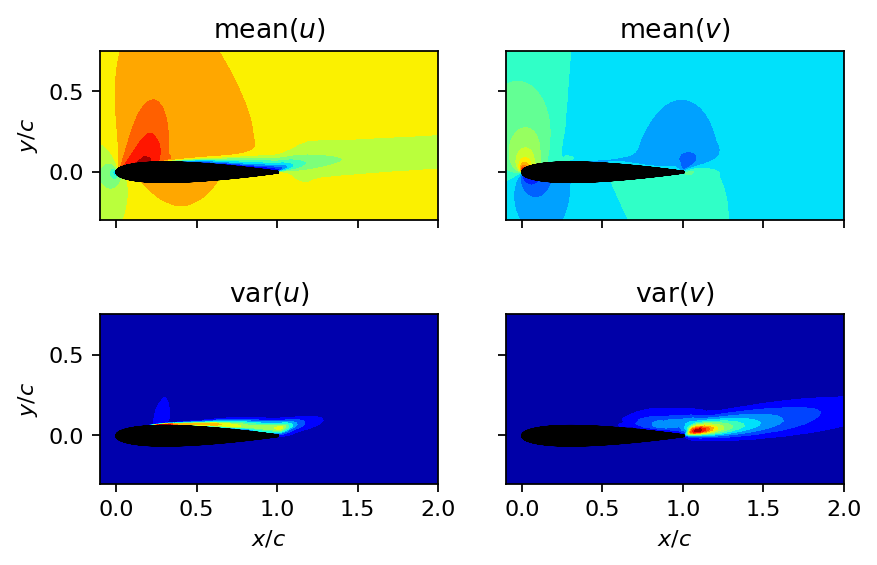

In [34]:
fig, axarr = plt.subplots(2, 2, sharex=True, sharey=True)
axarr[0, 0].tricontourf(xa, ya, Uxy[:, 0, :].mean(dim=1), levels=14, cmap="jet")
axarr[0, 1].tricontourf(xa, ya, Uxy[:, 1, :].mean(dim=1), levels=14, cmap="jet")
axarr[1, 0].tricontourf(xa, ya, Uxy[:, 0, :].var(dim=1), levels=14, cmap="jet")
axarr[1, 1].tricontourf(xa, ya, Uxy[:, 1, :].var(dim=1), levels=14, cmap="jet")

for ax in axarr.flatten():  
    add_naca0012_patch(ax)
    ax.set_aspect("equal", 'box')
    ax.set_xlim(-0.1, 2.0)
    ax.set_ylim(-0.3, 0.75)
axarr[1, 0].set_xlabel(r"$x/c$")
axarr[1, 1].set_xlabel(r"$x/c$")
axarr[0, 0].set_ylabel(r"$y/c$")
axarr[1, 0].set_ylabel(r"$y/c$")
axarr[0, 0].set_title(r"$\mathrm{mean}(u)$")
axarr[0, 1].set_title(r"$\mathrm{mean}(v)$")
axarr[1, 0].set_title(r"$\mathrm{var}(u)$")
axarr[1, 1].set_title(r"$\mathrm{var}(v)$")
plt.savefig(f"{output}/naca_mean_var.svg", bbox_inches="tight")
plt.savefig(f"{output}/naca_mean_var.png", bbox_inches="tight")

In [35]:
n_points = Uxy.shape[0]
data_matrix = pt.zeros((n_points*2, Uxy.shape[-1]))
weights = pt.sqrt(vol).unsqueeze(-1)
data_matrix[:n_points, :] = Uxy[:, 0, :]*weights
data_matrix[n_points:, :] = Uxy[:, 1, :]*weights
data_matrix -= data_matrix.mean(dim=1).unsqueeze(-1)
U, s, VH = pt.linalg.svd(data_matrix, full_matrices=False)

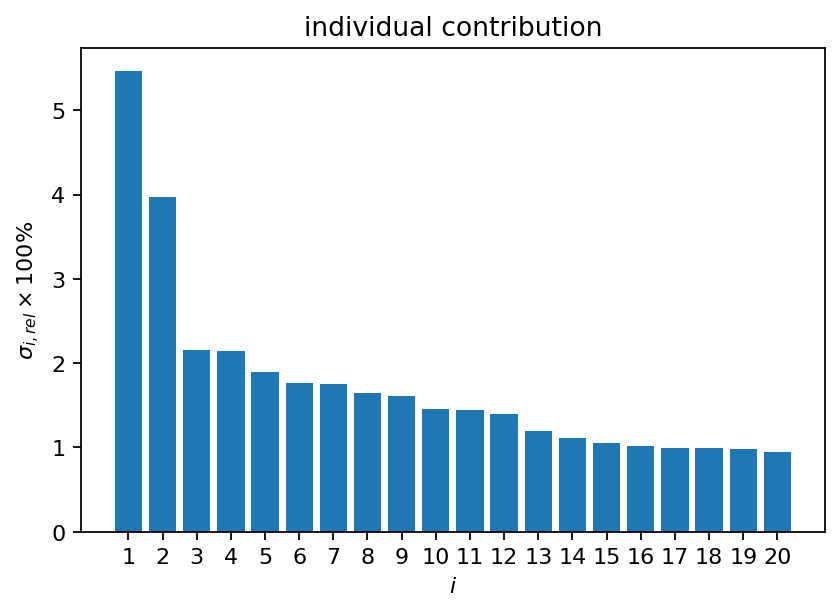

In [36]:
plt.bar(range(1, 21), s[:20]/s.sum()*100)
plt.gca().set_xticks(range(1, 21))
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,rel} \times 100\%$")
plt.title("individual contribution")
plt.savefig(f"{output}/naca_sing_vals.svg", bbox_inches="tight")

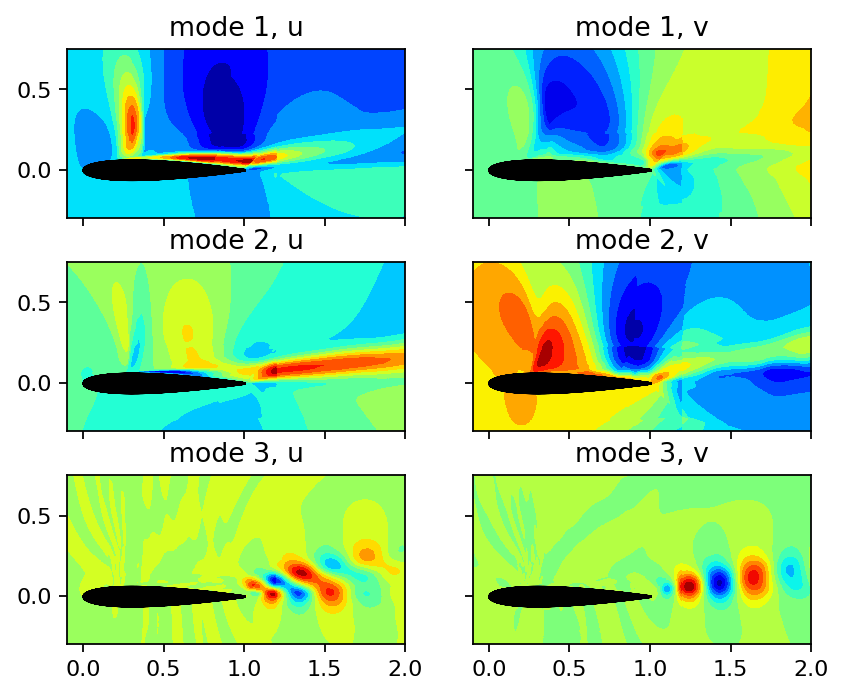

In [37]:
fig, axarr = plt.subplots(3, 2, figsize=(6, 5), sharex=True, sharey=True)

for i in range(3):
    axarr[i, 0].tricontourf(xa, ya, U[:n_points, i], levels=14, cmap="jet")
    axarr[i, 1].tricontourf(xa, ya, U[n_points:, i], levels=14, cmap="jet")
    for ax in axarr[i, :]:  
        add_naca0012_patch(ax)
        ax.set_aspect("equal", 'box')
        ax.set_xlim(-0.1, 2.0)
        ax.set_ylim(-0.3, 0.75)
    axarr[i, 0].set_title(f"mode {i+1}, u")
    axarr[i, 1].set_title(f"mode {i+1}, v")
plt.savefig(f"{output}/naca_pod_modes.png", bbox_inches="tight")

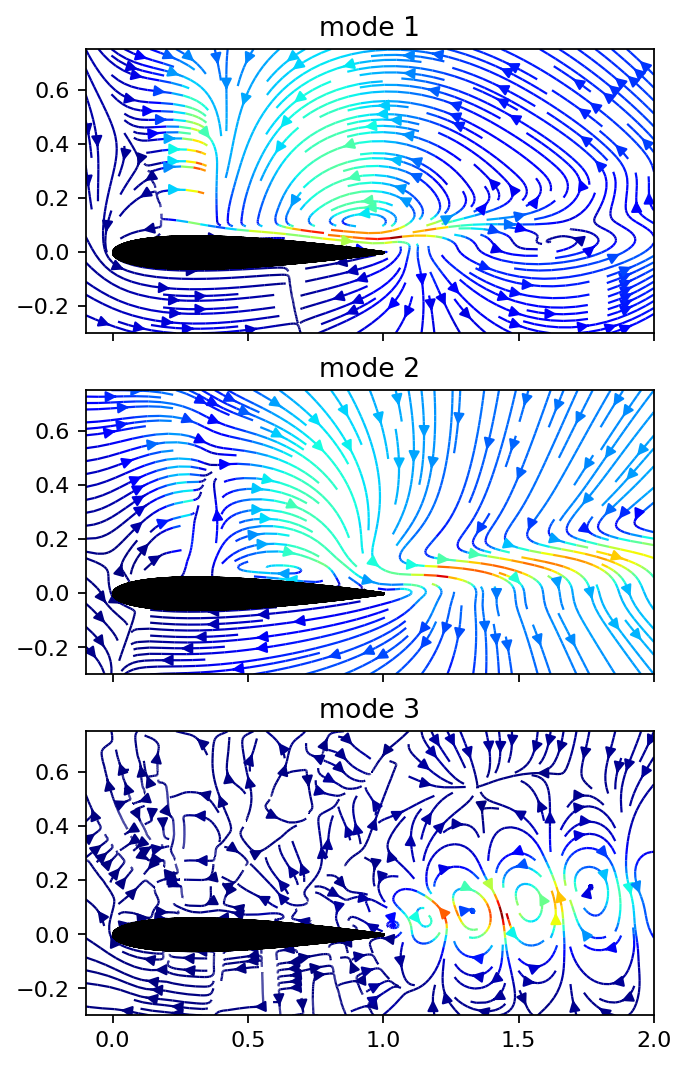

In [38]:
fig, axarr = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

triang = tri.Triangulation(xa, ya)
xi = np.linspace(-0.1, 2.0, 100)
yi = np.linspace(-0.3, 0.75, int(100*0.75/2.0))
Xi, Yi = np.meshgrid(xi, yi)

for i in range(3):
    interpolatorU = tri.LinearTriInterpolator(triang, U[:n_points, i].numpy())
    interpolatorV = tri.LinearTriInterpolator(triang, U[n_points:, i].numpy())
    Ui = interpolatorU(Xi, Yi)
    Vi = interpolatorV(Xi, Yi)
    mag = np.sqrt(Ui**2 + Vi**2)
    axarr[i].streamplot(xi, yi, Ui, Vi, color=mag, density=1.5, cmap="jet", linewidth=1)
    add_naca0012_patch(axarr[i])
    axarr[i].set_aspect("equal", 'box')
    axarr[i].set_xlim(-0.1, 2.0)
    axarr[i].set_ylim(-0.3, 0.75)
    axarr[i].set_title(f"mode {i+1}")
plt.savefig(f"{output}/naca_pod_modes_streamlines.png", bbox_inches="tight")

## Dynamic mode decomposition

In [39]:
X = pt.stack((Up_p1, Up_p2))
U, s, VT = pt.linalg.svd(X[:, :-1], full_matrices=False)
A = X[:, 1:] @ VT.T @ pt.diag(1/s) @ U.T
A

tensor([[ 0.4526, -0.4412],
        [ 0.0749,  0.9579]])

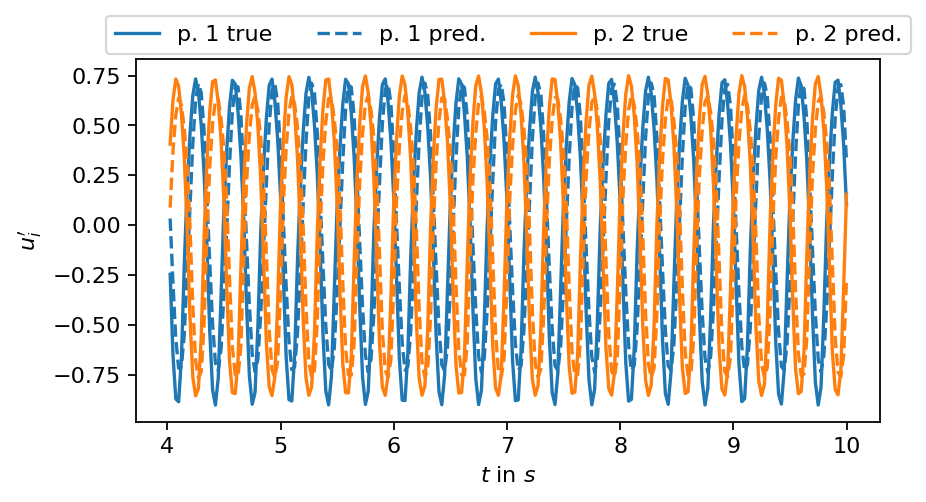

In [52]:
Xpred = A @ X[:, :-1]
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(times_num[1:], X[0, 1:], c="C0", ls="-", label="p. 1 true")
ax.plot(times_num[1:], Xpred[0, :], c="C0", ls="--", label="p. 1 pred.")
ax.plot(times_num[1:], X[1, 1:], c="C1", ls="-", label="p. 2 true")
ax.plot(times_num[1:], Xpred[1, :], c="C1", ls="--", label="p. 2 pred.")
ax.set_xlabel(r"$t$ in $s$")
ax.set_ylabel(r"$u_i^\prime$")
ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.15))
plt.savefig(f"{output}/dmd_probes_prediction.svg", bbox_inches="tight")

In [54]:
Xpred = pt.zeros_like(Xpred)
Xpred[:, 0] = A @ X[:, 0]
for n in range(1, X.shape[1]-1):
    Xpred[:, n] = A @ Xpred[:, n-1]

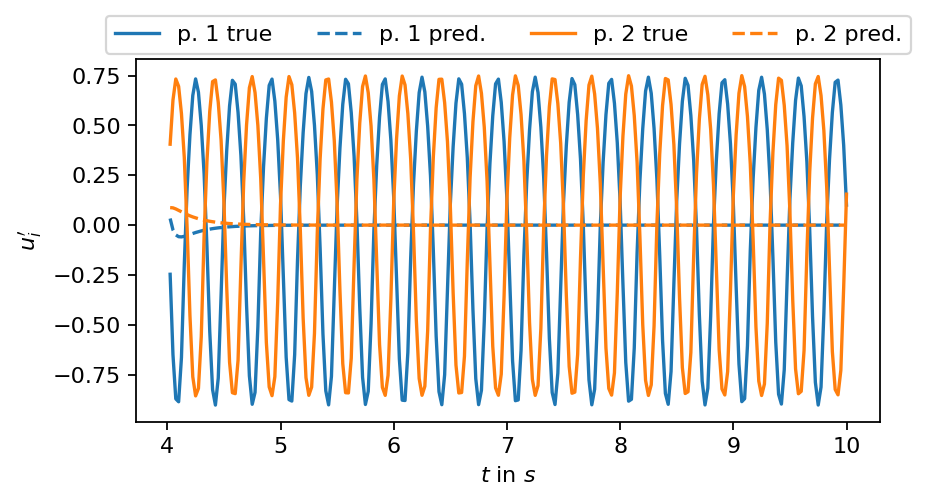

In [55]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(times_num[1:], X[0, 1:], c="C0", ls="-", label="p. 1 true")
ax.plot(times_num[1:], Xpred[0, :], c="C0", ls="--", label="p. 1 pred.")
ax.plot(times_num[1:], X[1, 1:], c="C1", ls="-", label="p. 2 true")
ax.plot(times_num[1:], Xpred[1, :], c="C1", ls="--", label="p. 2 pred.")
ax.set_xlabel(r"$t$ in $s$")
ax.set_ylabel(r"$u_i^\prime$")
ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.15))
plt.savefig(f"{output}/dmd_probes_prediction_steps.svg", bbox_inches="tight")

In [60]:
vals, vecs = pt.linalg.eig(A)
print(vecs.norm(dim=0))
vals, vecs

tensor([1.0000, 1.0000])


(tensor([0.5298+0.j, 0.8807+0.j]),
 tensor([[-0.9850+0.j,  0.7177+0.j],
         [ 0.1723+0.j, -0.6964+0.j]]))

In [66]:
U, s, VT = pt.linalg.svd(Up[:, :-1], full_matrices=False)
A = Up[:, 1:] @ VT.T @ pt.diag(1.0/s) @ U.T
print("Shape of linear operator:", A.shape)
vals, vecs = pt.linalg.eig(A)

Shape of linear operator: torch.Size([7190, 7190])


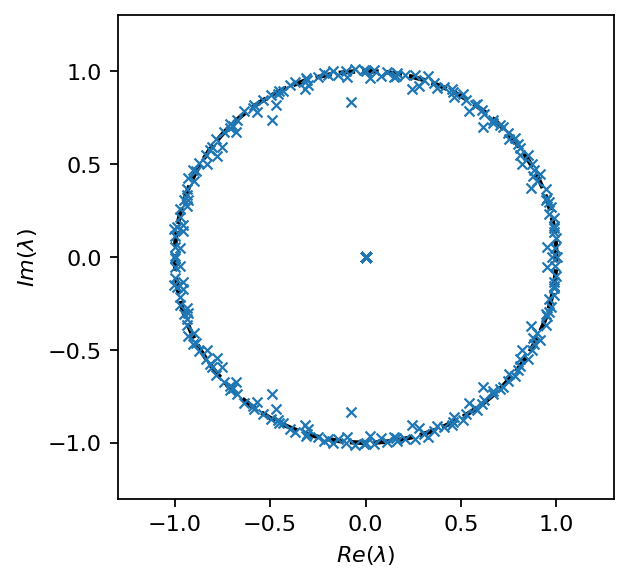

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(vals.real, vals.imag, marker="x", lw=1, s=20, zorder=7)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
plt.savefig(f"{output}/cylinder_eigvals_direct.svg", bbox_inches="tight")